In [8]:
# https://www.tensorflow.org/tutorials/keras/regression

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import os.path
from os import path

from ttictoc import TicToc


In [2]:
# Handle raw data

datadir = '/scratch/mattfel/raw_timetool/u1/coffee/2dtimetool_simulation_data/raw/'

raw_dataset = pd.DataFrame()
for fileId in range(1,99999):
    fileType = 'interference'
    if (fileId % 100 == 0): print('at %d' % fileId)
    f = datadir + '/chirp-2000_interferedelay1650_photonen6.0_carriertagdiamond_nfibers109_netalon1_1.00_1.00_%s.out.%d' % (fileType,fileId)
    if (path.exists(f)):
        rawdata = pd.read_csv(f, 
                          skiprows = 7, usecols = [i for i in range(1024)], header=None,
                          na_values = "?", comment='\t',
                          sep="\t|,", skipinitialspace=True)
        raw_dataset = raw_dataset.append(rawdata)
    else:
        print('file %d does not exist!' % fileId)
    if (fileId % 5000 == 0 or fileId == 99999):
        print('Writing feather %d' % fileId)
        raw_dataset.to_feather('./raw_signals_%d.feather' % fileId)
        raw_dataset = pd.DataFrame()
# raw_dataset = tf.stack([raw_dataset], axis=2)


raw_labels = pd.DataFrame()
for fileId in fileIds:
    fileType = 'fibermap'
    if (fileId % 100 == 0): print('at %d' % fileId)
    f = datadir + '/chirp-2000_interferedelay1650_photonen6.0_carriertagdiamond_nfibers109_netalon1_1.00_1.00_%s.out.%d' % (fileType,fileId)
    if (path.exists(f)):
        rawdata = pd.read_csv(f, 
                          skiprows = 1, usecols = [6], 
                          na_values = "?", comment='\t',
                          sep="\t|,", skipinitialspace=True)
        raw_labels = raw_labels.append(rawdata)
    else:
        print('file %d does not exist!' % fileId)
    if (fileId % 5000 == 0 or fileId == 99999):
        print('Writing feather %d' % fileId)
        raw_labels.to_feather('./raw_labels_%d.feather' % fileId)
        raw_labels = pd.DataFrame()


# print(raw_labels)
# print(raw_dataset.iloc[109])

/home/mattfel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mattfel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-64fd6406db38>", line 14, in <module>
    sep="\t|,", skipinitialspace=True)
  File "/home/mattfel/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 702, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/mattfel/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 435, in _read
    data = parser.read(nrows)
  File "/home/mattfel/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1139, in read
    ret = self._engine.read(nrows)
  File "/home/mattfel/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 2421, in read
    data = self._convert_data(data)
  File "/home/mattfel/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 2487, in _convert_data
    clean_conv, clean_dtyp

KeyboardInterrupt: 

In [22]:
# Handle processed data
column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'first_val', 'last_val', 'delay']
t = TicToc() ## TicToc("name")
t.tic()

raw_dataset = pd.read_csv('/local/ssd/home/mattfel/slac/timetool-ML-models/preprocessing/processed.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)
t.toc()
print('loaded dataset')
print(t.elapsed)

t.tic()
raw_dataset.to_feather('processed.feather')
t.toc()
print('stored dataset')
print(t.elapsed)




/home/mattfel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


loaded dataset
46.198360443115234


ArrowTypeError: ("Expected a bytes object, got a 'int' object", 'Conversion failed for column fileId with type object')

In [7]:
# Handle processed data with edge-from-floor rule
column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'first_val', 'last_val', 'delay']
t = TicToc() ## TicToc("name")
t.tic()

raw_dataset = pd.read_csv('/scratch/mattfel/data-fs/processed_floor.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)
t.toc()
print('loaded dataset')
print(t.elapsed)

t.tic()
raw_dataset.to_feather('/scratch/mattfel/data-fs/processed_floor.feather')
t.toc()
print('stored dataset')
print(t.elapsed)




loaded dataset
21.16840434074402
stored dataset
1.3687145709991455


In [2]:
raw_dataset =  pd.read_feather('./processed.feather')

ArrowIOError: Failed to open local file './processed.feather', error: No such file or directory

In [ ]:
def filterBad(dataset):
    initial_len = len(dataset)
    dataset = dataset[(dataset['rising_idx'] != 0)]
    dataset = dataset[(dataset['falling_idx'] != 0)]
#     dataset = dataset[(dataset['volume'] > 500)]
    dataset = dataset[(dataset['first_val'] < 30)]
    dataset = dataset[(dataset['last_val'] < 30)]
    final_len = len(dataset)
    print('Rejected %d points (%f%%)' % ((initial_len-final_len), (initial_len-final_len)/initial_len))
    return dataset
    
raw_dataset = filterBad(raw_dataset)


In [76]:

inspect = raw_dataset[(raw_dataset['rising_idx'] < 1000) & (raw_dataset['delay'] < -5000)]
print(inspect)

          fileId  row  rising_idx  falling_idx  volume  rising_weight  \
66958        604   76         452          809     708       0.499798   
66976        604   94         334          925     595       0.499798   
1219221    11181  100         838          928     534       0.750531   
1823923    16727   70         372          986     612       0.499933   
3077526    28230   64         333          987     664       0.499798   
3077568    28230  106         333          987     664       0.499798   
3324932    30496   40         960          991     523       1.756750   
3324956    30496   64         783          993    1011       0.668632   
3324986    30496   94         584          987     767       0.499798   
3324992    30496  100         539          988     882       0.499798   
3995960    36656   64         452          868     852       0.499798   
3996002    36656  106         494          866     728       0.499798   
4192504    38457   81         333          988     

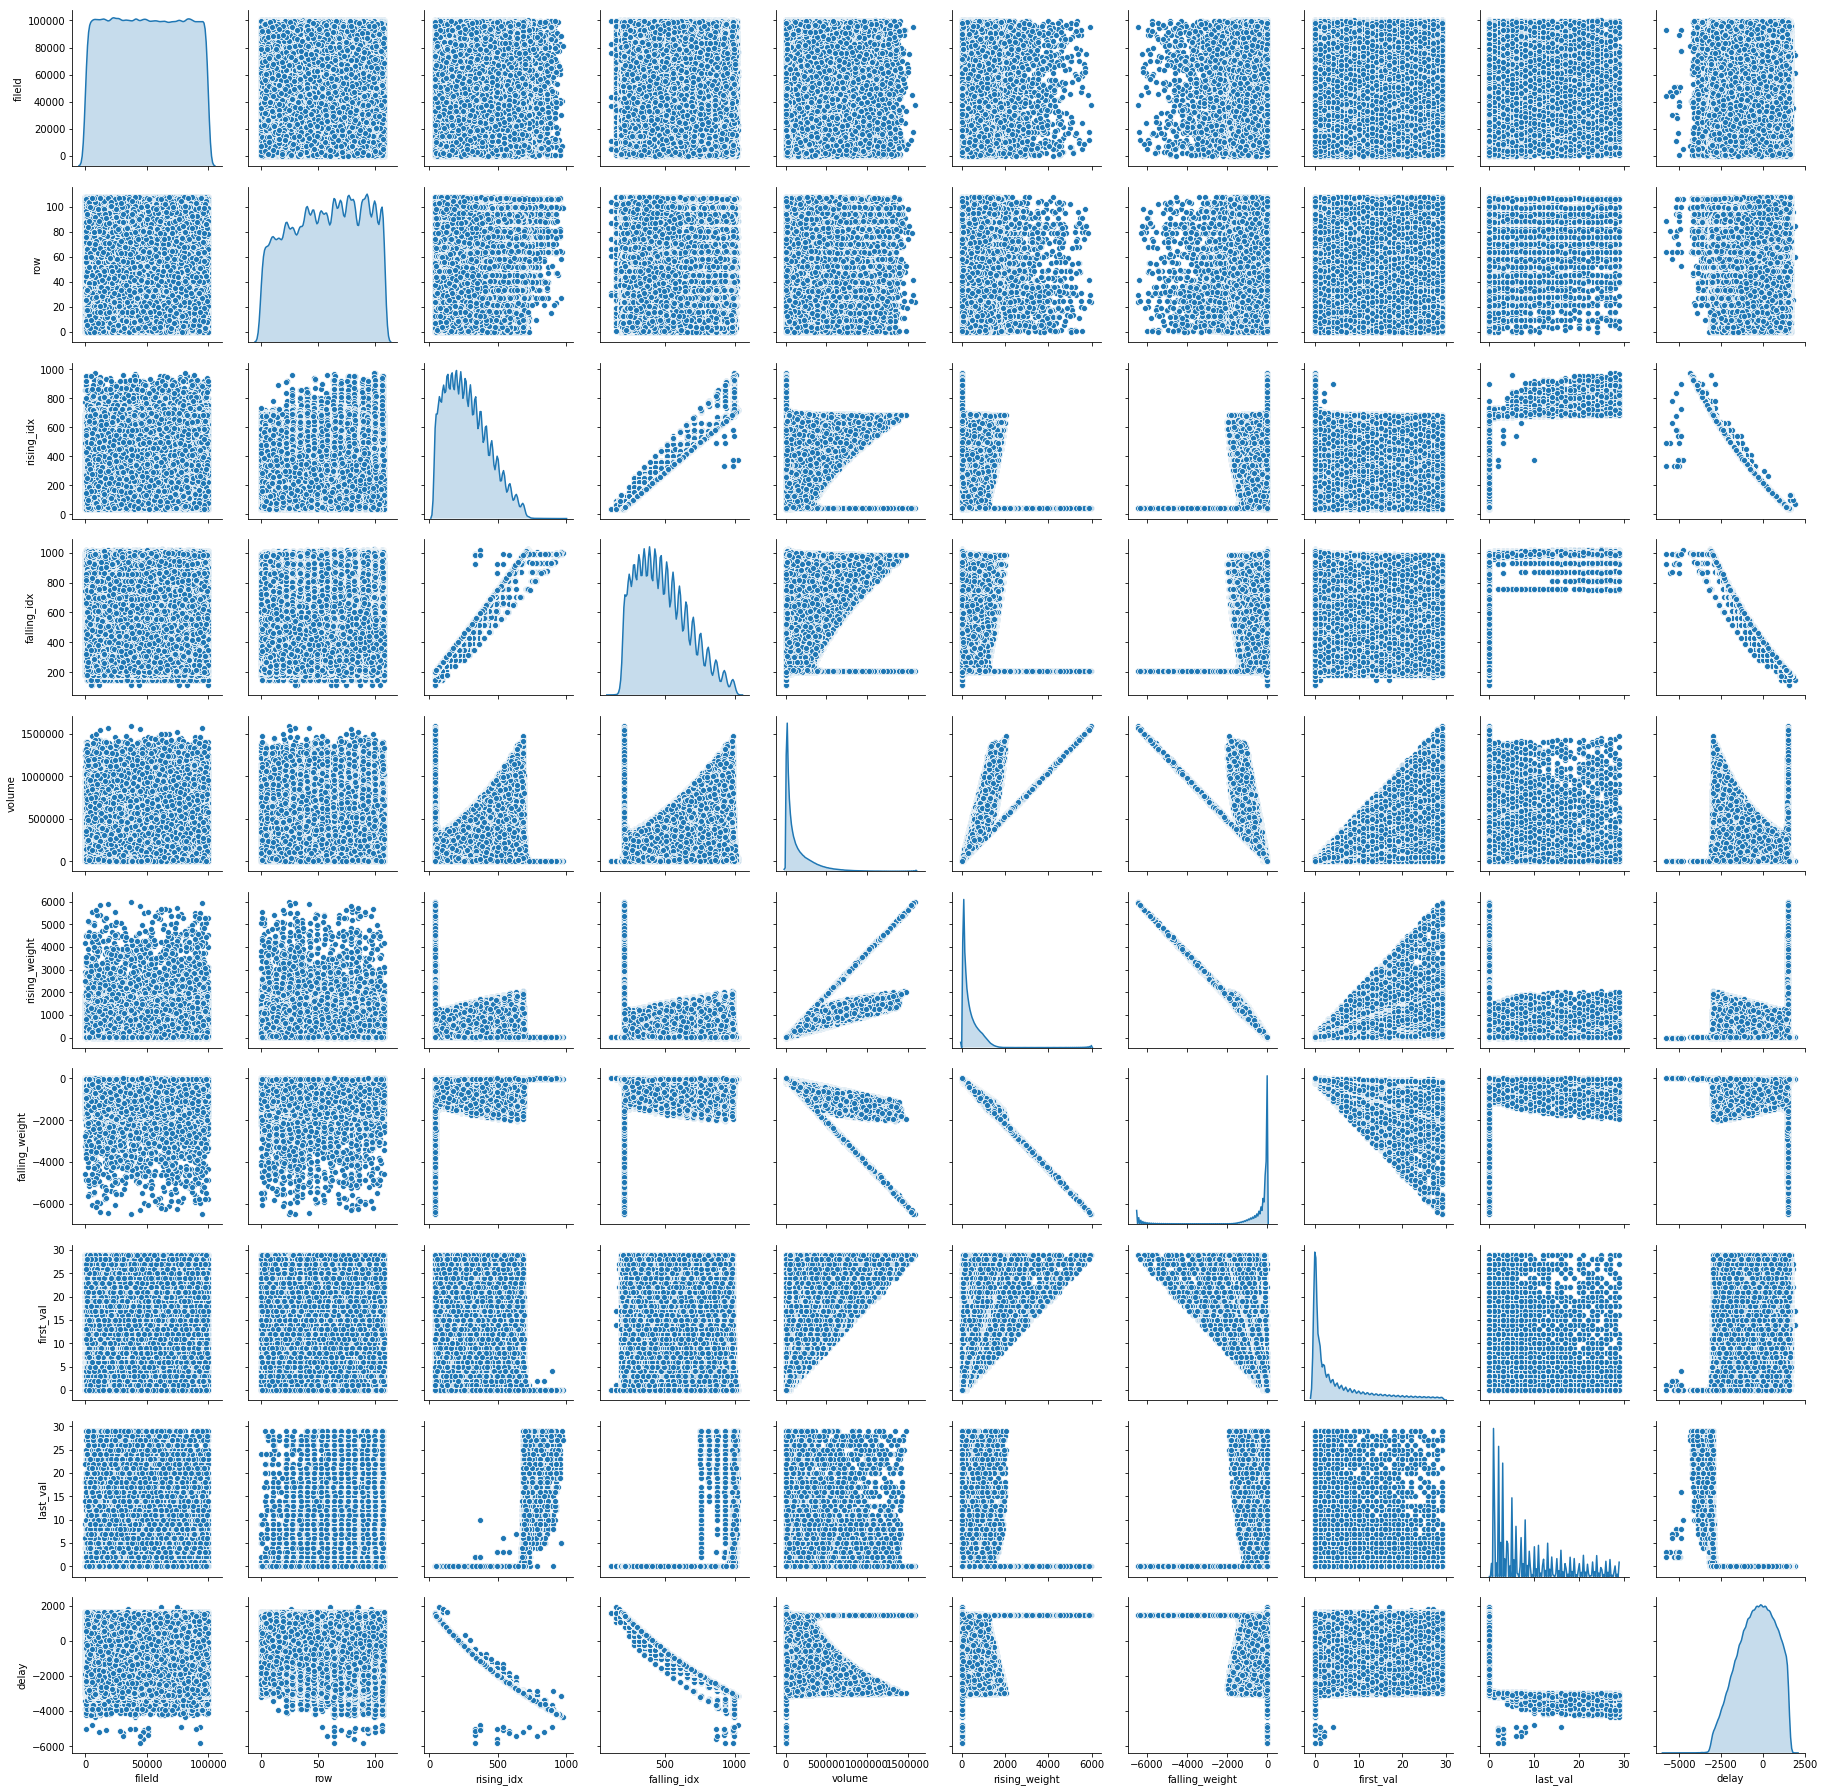

In [79]:
visualize_dataset = raw_dataset.sample(frac=0.3 )
sns.pairplot(visualize_dataset[column_names], diag_kind="kde")

In [68]:
def loadAndFilter():
    raw_dataset =  pd.read_feather('../preprocessing/processed.feather')
    dataset = filterBad(raw_dataset)
    visualize_dataset = dataset.sample(frac=0.01)
    sns.pairplot(visualize_dataset[["row", "rising_idx", "falling_idx", "volume", "rising_weight", "falling_weight", "delay"]], diag_kind="kde")
    return dataset

# Visualize strong points

In [1]:
# Import helpers
import import_ipynb
from common import buildDataset
from common import filterBad
from common import splitDataset
from common import normDataset
from common import evaluatePerf
from common import evaluateCustom
from common import extractNNWeights

importing Jupyter notebook from common.ipynb


In [2]:
only_use_strong = 54

dataset, columns = buildDataset()
dataset = filterBad(dataset, only_use_strong)
train_dataset, test_dataset, train_labels, test_labels = splitDataset(dataset, 0.1)
train_stats = train_dataset.describe().transpose()

# FCNN-specific
normed_train_data = normDataset(train_dataset, train_stats)
normed_test_data = normDataset(test_dataset, train_stats)

# print(train_dataset)
# print(normed_train_data)

Rejected 6196746 points (56.847699%)


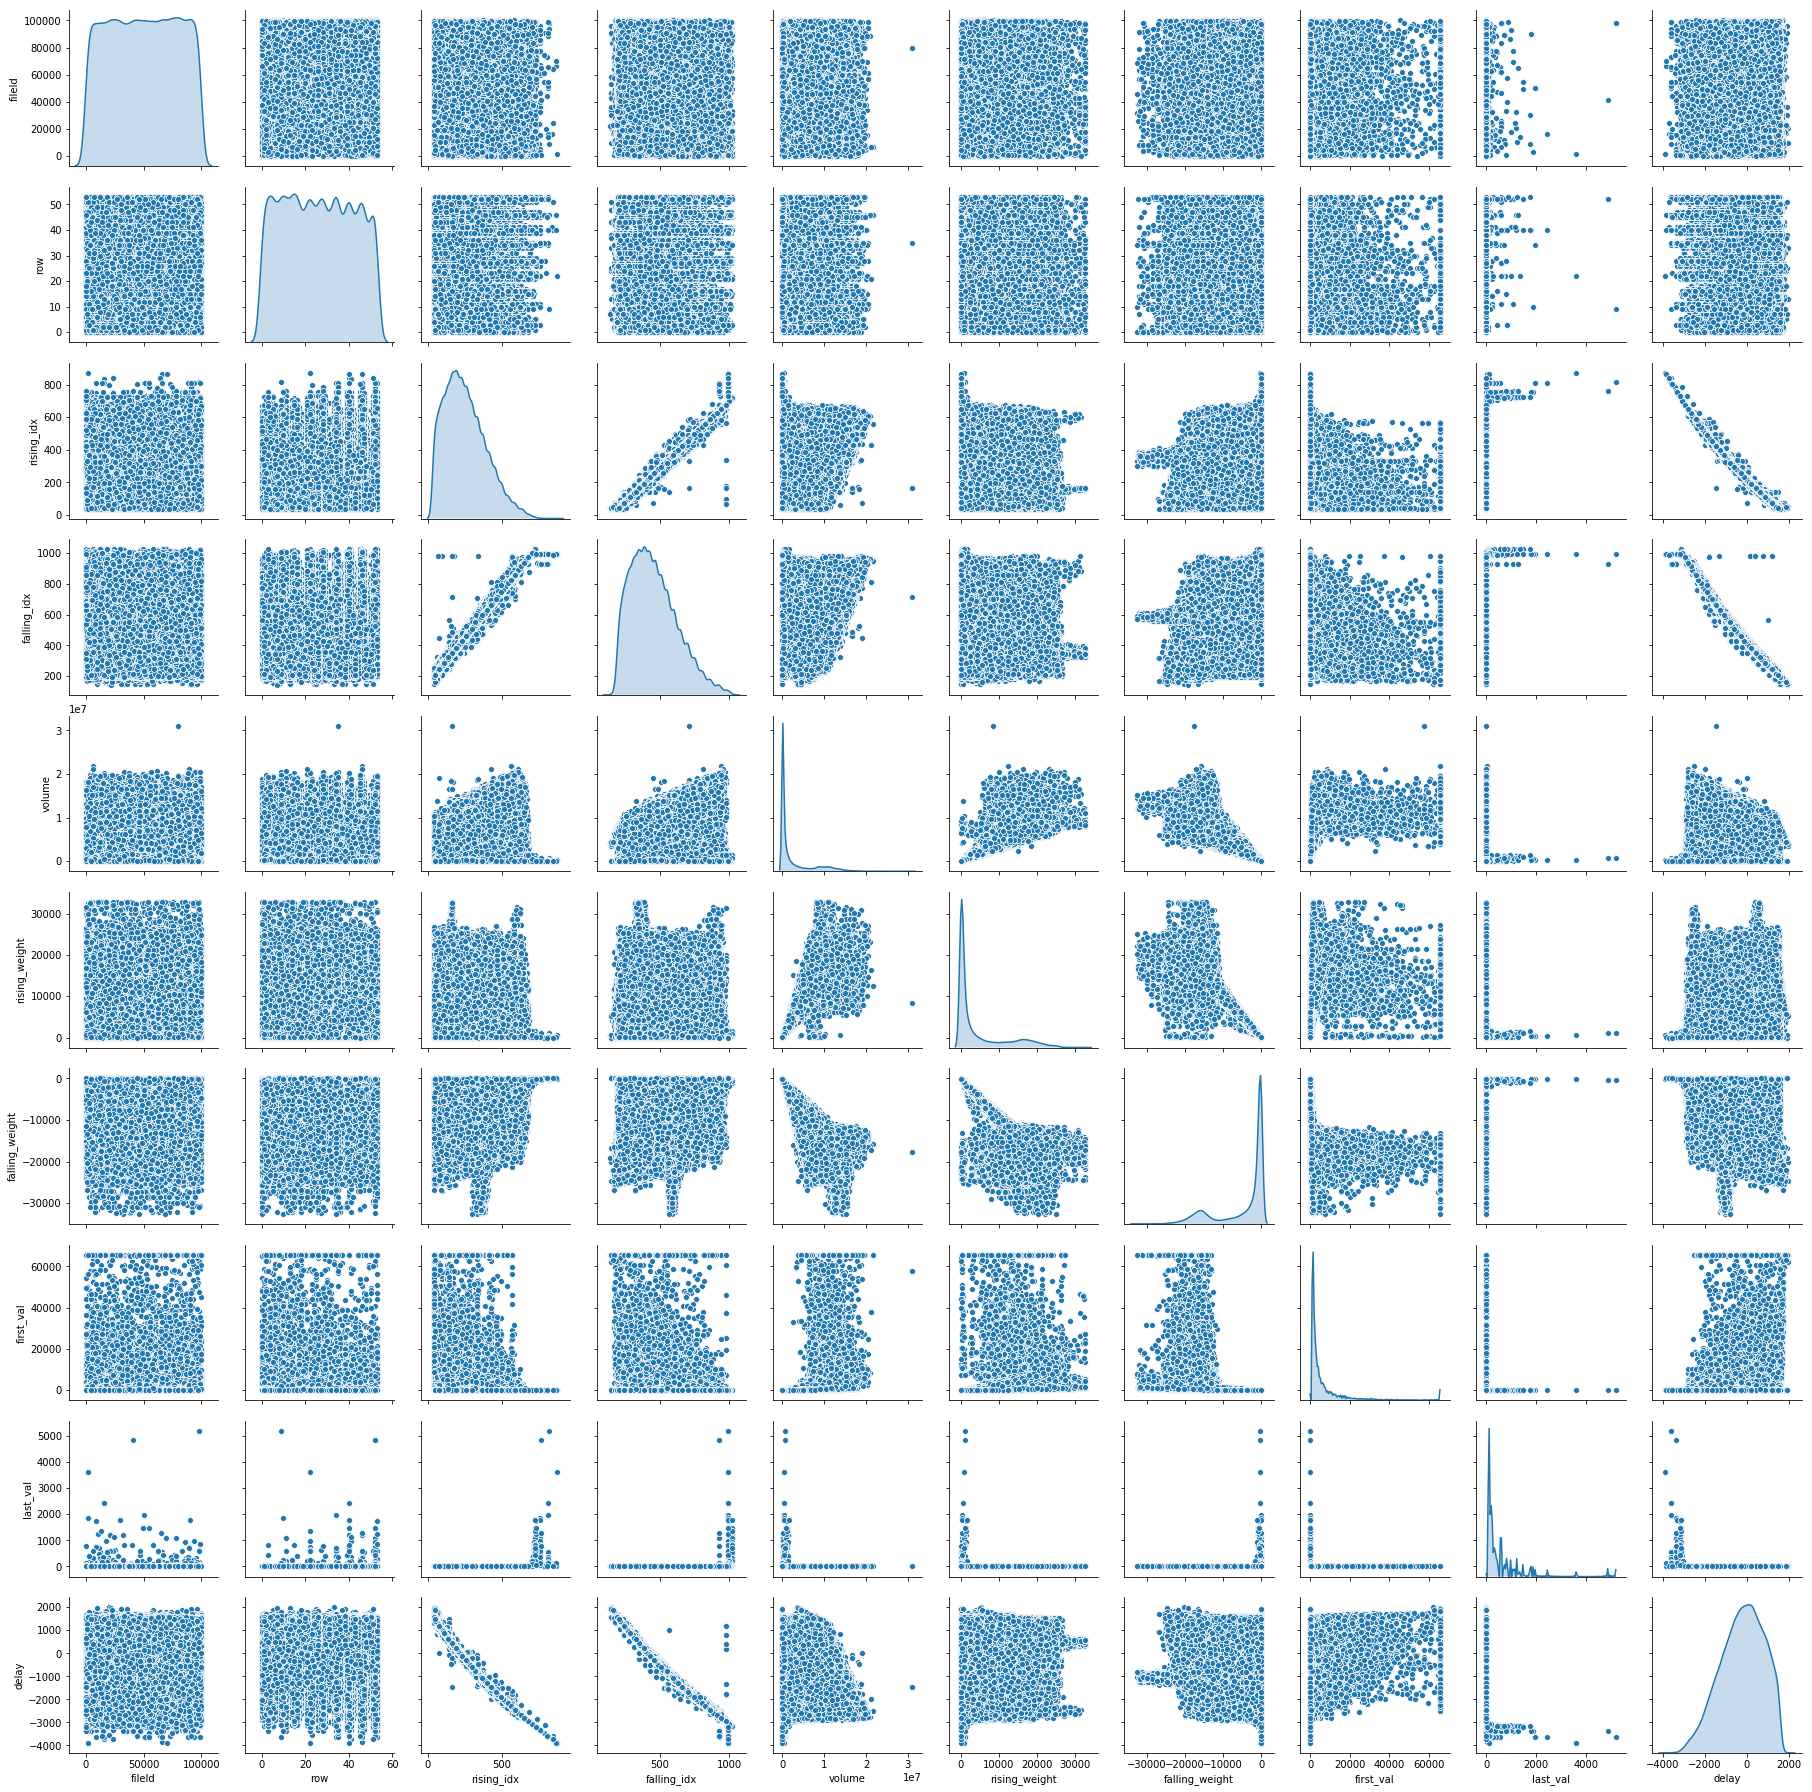

In [5]:
column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'first_val', 'last_val', 'delay']
visualize_dataset = dataset.sample(frac=0.03 )
sns.pairplot(visualize_dataset[column_names], diag_kind="kde")

# Experimenting with floor metric

In [17]:
import pandas as pd
column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
            'falling_weight', 'first_val', 'last_val', 'delay']

# raw_dataset =  pd.read_feather('../preprocessing/processed.feather')
#     raw_dataset =  pd.read_feather('/local/ssd/home/mattfel/slac/timetool-ML-models/preprocessing/processed.feather')
dataset =  pd.read_feather('/scratch/mattfel/data-fs/processed_floor.feather')

init = len(dataset)
dataset = dataset[(dataset['rising_idx'] != 0)]
print('deleted %d (%f) points from criterion 1' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))

init = len(dataset)
dataset = dataset[(dataset['falling_idx'] != 0)]
print('deleted %d (%f) points from criterion 2' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))

init = len(dataset)
dataset = dataset[(dataset['falling_idx'] - dataset['rising_idx'] > 100)]
print('deleted %d (%f) points from criterion 3' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))

init = len(dataset)
dataset = dataset[(dataset['first_val'] < 30) | (dataset['last_val'] < 30)]
print('deleted %d (%f) points from criterion 4' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))


print('\n\n')



dataset =  pd.read_feather('/scratch/mattfel/data-fs/processed.feather')

init = len(dataset)
dataset = dataset[(dataset['rising_idx'] != 0)]
print('deleted %d (%f) points from criterion 1' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))

init = len(dataset)
dataset = dataset[(dataset['falling_idx'] != 0)]
print('deleted %d (%f) points from criterion 2' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))

init = len(dataset)
dataset = dataset[(dataset['falling_idx'] - dataset['rising_idx'] > 100)]
print('deleted %d (%f) points from criterion 3' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))

init = len(dataset)
dataset = dataset[(dataset['first_val'] < 30) | (dataset['last_val'] < 30)]
print('deleted %d (%f) points from criterion 4' % (init - len(dataset), 100.0 * (init - len(dataset)) / init))



deleted 253851 (2.328778) points from criterion 2
deleted 1162992 (10.923437) points from criterion 3
deleted 5488 (0.057867) points from criterion 4



deleted 213994 (1.963138) points from criterion 2
deleted 1750383 (16.379207) points from criterion 3
deleted 18395 (0.205847) points from criterion 4


In [32]:

dataset =  pd.read_feather('/scratch/mattfel/data-fs/processed.feather')
kilt = pd.DataFrame()
for i,x in dataset.iterrows():
    if (x['rising_idx'] == 0):
        kilt = kilt.append(x)
    if i > 10000:
        break


fileId              2.00
row                38.00
rising_idx          0.00
falling_idx         0.00
volume              0.00
rising_weight       0.00
falling_weight      0.00
first_val           0.00
last_val            0.00
delay             796.81
Name: 160, dtype: float64
fileId               3.00
row                 37.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             2310.63
Name: 220, dtype: float64
fileId               3.00
row                 38.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             1578.57
Name: 221, dtype: float64
fileId              4.000
row                19.000
rising_idx          0.000
falling_idx         0.000
volume              0.000
rising_weight       0.

fileId                 30.0
row                    25.0
rising_idx              0.0
falling_idx           133.0
volume            7984145.0
rising_weight           0.0
falling_weight     -23696.3
first_val           65535.0
last_val                0.0
delay                2035.5
Name: 853, dtype: float64
fileId                 30.00
row                    30.00
rising_idx              0.00
falling_idx           168.00
volume            9830788.00
rising_weight           0.00
falling_weight     -20389.20
first_val           65535.00
last_val                0.00
delay                1852.18
Name: 858, dtype: float64
fileId                 30.0
row                    31.0
rising_idx              0.0
falling_idx           138.0
volume            8186758.0
rising_weight           0.0
falling_weight     -19646.6
first_val           65535.0
last_val                0.0
delay                2035.5
Name: 859, dtype: float64
fileId                 30.00
row                    32.00
rising_idx    

fileId               8.0000
row                 91.0000
rising_idx           0.0000
falling_idx         40.0000
volume            5749.0000
rising_weight        0.0000
falling_weight     -28.1693
first_val          902.0000
last_val             0.0000
delay             3116.6100
Name: 2772, dtype: float64
fileId               8.0000
row                 96.0000
rising_idx           0.0000
falling_idx         40.0000
volume            2310.0000
rising_weight        0.0000
falling_weight     -11.1116
first_val          362.0000
last_val             0.0000
delay             3116.6100
Name: 2777, dtype: float64
fileId               8.000000
row                 97.000000
rising_idx           0.000000
falling_idx         40.000000
volume              79.000000
rising_weight        0.000000
falling_weight      -0.211311
first_val           19.000000
last_val             0.000000
delay             3299.930000
Name: 2778, dtype: float64
fileId               8.0000
row                102.0000
ris

fileId              15.00
row                 37.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             1849.58
Name: 4135, dtype: float64
fileId             15.000
row                41.000
rising_idx          0.000
falling_idx         0.000
volume              0.000
rising_weight       0.000
falling_weight      0.000
first_val           0.000
last_val            0.000
delay            -350.199
Name: 4139, dtype: float64
fileId              15.00
row                 42.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             1116.32
Name: 4140, dtype: float64
fileId              15.00
row                 48.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_we

Name: 4194, dtype: float64
fileId              15.00
row                 97.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             2216.21
Name: 4195, dtype: float64
fileId             15.000
row                98.000
rising_idx          0.000
falling_idx         0.000
volume              0.000
rising_weight       0.000
falling_weight      0.000
first_val           0.000
last_val            0.000
delay             749.692
Name: 4196, dtype: float64
fileId              15.00
row                 99.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay            -1083.46
Name: 4197, dtype: float64
fileId              15.00
row                100.00
rising_idx           0.00
falling_idx          0.00
volume  

fileId              46.00
row                 61.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             1144.17
Name: 5467, dtype: float64
fileId             46.000
row                62.000
rising_idx          0.000
falling_idx         0.000
volume              0.000
rising_weight       0.000
falling_weight      0.000
first_val           0.000
last_val            0.000
delay             227.595
Name: 5468, dtype: float64
fileId              46.00
row                 63.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay            -1605.56
Name: 5469, dtype: float64
fileId             46.000
row                68.000
rising_idx          0.000
falling_idx         0.000
volume              0.000
rising_we

fileId              70.00
row                 61.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             3315.19
Name: 8846, dtype: float64
fileId              70.00000
row                 67.00000
rising_idx           0.00000
falling_idx         40.00000
volume             314.00000
rising_weight        0.00000
falling_weight      -1.27171
first_val           53.00000
last_val             0.00000
delay             3131.87000
Name: 8852, dtype: float64
fileId              70.00000
row                 73.00000
rising_idx           0.00000
falling_idx         40.00000
volume             455.00000
rising_weight        0.00000
falling_weight      -1.87261
first_val           76.00000
last_val             0.00000
delay             3131.87000
Name: 8858, dtype: float64
fileId              70.0000
row                 84.0000
rising_idx           0.

fileId              84.00
row                 74.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             3631.93
Name: 9731, dtype: float64
fileId               84.0000
row                  78.0000
rising_idx            0.0000
falling_idx          40.0000
volume            10642.0000
rising_weight         0.0000
falling_weight      -61.5606
first_val          1375.0000
last_val              0.0000
delay              3081.9800
Name: 9735, dtype: float64
fileId              84.00
row                 79.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             3815.25
Name: 9736, dtype: float64
fileId              84.00
row                 84.00
rising_idx           0.00
falling_idx          0.00
volum

fileId              88.00
row                 79.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             3977.85
Name: 9845, dtype: float64
fileId              88.0000
row                 83.0000
rising_idx           0.0000
falling_idx         49.0000
volume            1677.0000
rising_weight        0.0000
falling_weight     -18.3775
first_val           61.0000
last_val             0.0000
delay             2877.9500
Name: 9849, dtype: float64
fileId              88.00
row                 84.00
rising_idx           0.00
falling_idx          0.00
volume               0.00
rising_weight        0.00
falling_weight       0.00
first_val            0.00
last_val             0.00
delay             4161.16
Name: 9850, dtype: float64
fileId              88.00
row                 85.00
rising_idx           0.00
falling_idx          0.00
volume         

In [33]:
print(kilt)

         delay  falling_idx  falling_weight  fileId  first_val  last_val  \
160    796.810          0.0        0.000000     2.0        0.0       0.0   
220   2310.630          0.0        0.000000     3.0        0.0       0.0   
221   1578.570          0.0        0.000000     3.0        0.0       0.0   
263    944.631          0.0        0.000000     4.0        0.0       0.0   
281   1311.260          0.0        0.000000     4.0        0.0       0.0   
287   1128.350          0.0        0.000000     4.0        0.0       0.0   
299    945.429          0.0        0.000000     4.0        0.0       0.0   
634   2158.970        142.0   -14154.100000    19.0    65535.0       0.0   
640   2342.290        120.0   -22606.400000    19.0    65535.0       0.0   
646   1792.340        180.0   -21555.900000    19.0    65535.0       0.0   
647   3075.550         40.0   -14574.800000    19.0    65535.0       0.0   
648   2342.290        113.0   -22681.400000    19.0    65535.0       0.0   
652   2342.2

In [36]:

dataset =  pd.read_feather('/scratch/mattfel/data-fs/processed_floor.feather')
for i,x in dataset.iterrows():
    if (x['rising_idx'] == 0):
        print(x['fileId'])
        print(x['row'])
        match = kilt[(kilt['fileId'] == x['fileId'])]
        if (len(match) == 0):
            print(x)
    if i > 10000:
        break


1.0
0.0
fileId                  1.000
row                     0.000
rising_idx              0.000
falling_idx           515.000
volume            6729369.000
rising_weight           0.000
falling_weight       -372.652
first_val             262.000
last_val                0.000
delay                -446.351
Name: 61, dtype: float64
1.0
1.0
fileId            1.000000e+00
row               1.000000e+00
rising_idx        0.000000e+00
falling_idx       4.550000e+02
volume            5.787458e+06
rising_weight     0.000000e+00
falling_weight   -3.702960e+02
first_val         2.510000e+02
last_val          0.000000e+00
delay            -7.972080e+01
Name: 62, dtype: float64
1.0
2.0
fileId                  1.000
row                     2.000
rising_idx              0.000
falling_idx           486.000
volume            6628187.000
rising_weight           0.000
falling_weight       -297.681
first_val             274.000
last_val                0.000
delay                -262.936
Name: 63, dtype:

2.0
38.0
3.0
31.0
3.0
37.0
3.0
38.0
3.0
48.0
3.0
49.0
3.0
60.0
4.0
19.0
4.0
37.0
4.0
43.0
4.0
55.0
5.0
20.0
fileId                   5.00
row                     20.00
rising_idx               0.00
falling_idx            252.00
volume            12323535.00
rising_weight            0.00
falling_weight       -3512.09
first_val             2313.00
last_val                 0.00
delay                 1024.14
Name: 325, dtype: float64
6.0
0.0
fileId                  6.000
row                     0.000
rising_idx              0.000
falling_idx           574.000
volume            4209403.000
rising_weight           0.000
falling_weight       -173.958
first_val             148.000
last_val                0.000
delay                -788.583
Name: 366, dtype: float64
6.0
1.0
fileId                  6.000
row                     1.000
rising_idx              0.000
falling_idx           507.000
volume            3056952.000
rising_weight           0.000
falling_weight       -317.157
first_val     

0.0
fileId                  9.000
row                     0.000
rising_idx              0.000
falling_idx           394.000
volume            5131201.000
rising_weight           0.000
falling_weight       -484.987
first_val             254.000
last_val                0.000
delay                 304.273
Name: 549, dtype: float64
9.0
1.0
fileId                  9.000
row                     1.000
rising_idx              0.000
falling_idx           339.000
volume            4782910.000
rising_weight           0.000
falling_weight       -619.155
first_val             262.000
last_val                0.000
delay                 670.901
Name: 550, dtype: float64
9.0
2.0
fileId                  9.000
row                     2.000
rising_idx              0.000
falling_idx           367.000
volume            4899553.000
rising_weight           0.000
falling_weight       -414.603
first_val             255.000
last_val                0.000
delay                 488.485
Name: 551, dtype: float64
9.

19.0
65.0
19.0
66.0
19.0
67.0
19.0
68.0
19.0
69.0
19.0
70.0
19.0
71.0
19.0
72.0
19.0
73.0
19.0
74.0
19.0
75.0
19.0
76.0
19.0
77.0
19.0
78.0
19.0
79.0
19.0
81.0
19.0
82.0
19.0
83.0
19.0
84.0
19.0
85.0
19.0
86.0
19.0
87.0
19.0
88.0
19.0
89.0
19.0
91.0
19.0
92.0
19.0
95.0
19.0
96.0
19.0
97.0
19.0
98.0
19.0
99.0
19.0
101.0
19.0
102.0
19.0
103.0
19.0
104.0
19.0
105.0
19.0
108.0
0.0
6.0
fileId                  0.000
row                     6.000
rising_idx              0.000
falling_idx           458.000
volume            1300046.000
rising_weight           0.000
falling_weight       -239.420
first_val              56.000
last_val                0.000
delay                -146.922
Name: 725, dtype: float64
30.0
6.0
30.0
7.0
30.0
10.0
30.0
12.0
30.0
15.0
30.0
20.0
30.0
23.0
30.0
25.0
30.0
30.0
30.0
31.0
30.0
32.0
30.0
37.0
30.0
38.0
30.0
41.0
30.0
42.0
30.0
43.0
30.0
45.0
30.0
48.0
30.0
49.0
30.0
50.0
30.0
55.0
30.0
60.0
30.0
61.0
30.0
62.0
30.0
63.0
30.0
65.0
30.0
66.0
30.0
67.0
30.0
68.0
30

33.0
fileId            3.400000e+01
row               3.300000e+01
rising_idx        0.000000e+00
falling_idx       4.490000e+02
volume            3.837621e+06
rising_weight     0.000000e+00
falling_weight   -2.651150e+02
first_val         1.680000e+02
last_val          0.000000e+00
delay            -4.904940e+01
Name: 970, dtype: float64
34.0
34.0
fileId                 34.00
row                    34.00
rising_idx              0.00
falling_idx           575.00
volume            6091435.00
rising_weight           0.00
falling_weight       -203.87
first_val             212.00
last_val                0.00
delay                -782.31
Name: 971, dtype: float64
34.0
35.0
fileId                 34.000
row                    35.000
rising_idx              0.000
falling_idx           541.000
volume            5409663.000
rising_weight           0.000
falling_weight       -271.003
first_val             198.000
last_val                0.000
delay                -598.996
Name: 972, dtype: float

fileId                 24.000
row                     9.000
rising_idx              0.000
falling_idx           391.000
volume            6467016.000
rising_weight           0.000
falling_weight       -539.842
first_val             322.000
last_val                0.000
delay                 332.141
Name: 1273, dtype: float64
24.0
10.0
fileId            2.400000e+01
row               1.000000e+01
rising_idx        0.000000e+00
falling_idx       4.470000e+02
volume            4.383600e+06
rising_weight     0.000000e+00
falling_weight   -2.873180e+02
first_val         1.940000e+02
last_val          0.000000e+00
delay            -3.448980e+01
Name: 1274, dtype: float64
24.0
11.0
fileId                 24.000
row                    11.000
rising_idx              0.000
falling_idx           385.000
volume            2270453.000
rising_weight           0.000
falling_weight       -495.879
first_val             114.000
last_val                0.000
delay                 332.140
Name: 1275, dtyp

fileId                 24.000
row                    69.000
rising_idx              0.000
falling_idx           500.000
volume            1397312.000
rising_weight           0.000
falling_weight       -211.062
first_val              55.000
last_val                0.000
delay                -401.119
Name: 1333, dtype: float64
24.0
72.0
fileId               24.00
row                  72.00
rising_idx            0.00
falling_idx         170.00
volume            75479.00
rising_weight         0.00
falling_weight     -209.01
first_val           629.00
last_val              0.00
delay              1798.66
Name: 1336, dtype: float64
24.0
73.0
fileId               24.000
row                  73.000
rising_idx            0.000
falling_idx         106.000
volume            87768.000
rising_weight         0.000
falling_weight     -363.989
first_val          1022.000
last_val              0.000
delay              2348.600
Name: 1337, dtype: float64
24.0
74.0
fileId                24.000
row       

59.0
fileId                  18.00
row                     59.00
rising_idx               0.00
falling_idx            422.00
volume            11668847.00
rising_weight            0.00
falling_weight       -3659.82
first_val              486.00
last_val                 0.00
delay                 -268.50
Name: 1541, dtype: float64
18.0
60.0
fileId                 18.000
row                    60.000
rising_idx              0.000
falling_idx           312.000
volume            2145356.000
rising_weight           0.000
falling_weight       -656.659
first_val             126.000
last_val                0.000
delay                 831.390
Name: 1542, dtype: float64
18.0
61.0
fileId               18.000
row                  61.000
rising_idx            0.000
falling_idx         199.000
volume            95974.000
rising_weight         0.000
falling_weight     -205.486
first_val            38.000
last_val              0.000
delay              1564.650
Name: 1543, dtype: float64
18.0
64.0
file

16.0
55.0
16.0
60.0
16.0
61.0
16.0
62.0
16.0
66.0
16.0
67.0
16.0
68.0
16.0
72.0
16.0
73.0
16.0
74.0
16.0
78.0
16.0
79.0
16.0
84.0
16.0
85.0
16.0
86.0
16.0
91.0
16.0
96.0
16.0
97.0
16.0
102.0
16.0
103.0
16.0
104.0
6.0
20.0
fileId            6.000000e+00
row               2.000000e+01
rising_idx        0.000000e+00
falling_idx       4.660000e+02
volume            1.158082e+07
rising_weight     0.000000e+00
falling_weight   -4.716450e+03
first_val         4.500000e+02
last_val          0.000000e+00
delay            -5.390180e+02
Name: 1829, dtype: float64
6.0
37.0
fileId                  6.000
row                    37.000
rising_idx              0.000
falling_idx           382.000
volume            4613667.000
rising_weight           0.000
falling_weight       -561.800
first_val             232.000
last_val                0.000
delay                 377.557
Name: 1846, dtype: float64
6.0
38.0
fileId                  6.000
row                    38.000
rising_idx              0.000
fallin

fileId            6.000000e+00
row               7.600000e+01
rising_idx        0.000000e+00
falling_idx       9.770000e+02
volume            4.005620e+06
rising_weight     0.000000e+00
falling_weight   -7.550940e+01
first_val         7.200000e+01
last_val          0.000000e+00
delay            -2.738800e+03
Name: 1885, dtype: float64
6.0
77.0
fileId            6.000000e+00
row               7.700000e+01
rising_idx        0.000000e+00
falling_idx       8.520000e+02
volume            4.723145e+06
rising_weight     0.000000e+00
falling_weight   -9.725410e+01
first_val         1.030000e+02
last_val          0.000000e+00
delay            -2.188850e+03
Name: 1886, dtype: float64
6.0
78.0
fileId                  6.000
row                    78.000
rising_idx              0.000
falling_idx           529.000
volume            3609817.000
rising_weight           0.000
falling_weight       -203.862
first_val             136.000
last_val                0.000
delay                -539.019
Name: 18

5.0
39.0
6.0
39.0
7.0
39.0
8.0
39.0
12.0
39.0
13.0
39.0
14.0
39.0
17.0
39.0
18.0
39.0
19.0
39.0
20.0
39.0
24.0
39.0
25.0
39.0
26.0
39.0
29.0
39.0
30.0
39.0
31.0
39.0
32.0
39.0
33.0
39.0
36.0
39.0
37.0
39.0
38.0
39.0
42.0
39.0
43.0
39.0
44.0
39.0
48.0
39.0
49.0
39.0
50.0
39.0
54.0
39.0
55.0
39.0
56.0
39.0
59.0
39.0
60.0
39.0
61.0
39.0
62.0
39.0
66.0
39.0
67.0
39.0
68.0
39.0
72.0
39.0
73.0
39.0
74.0
39.0
78.0
39.0
79.0
39.0
83.0
39.0
84.0
39.0
85.0
39.0
86.0
39.0
87.0
39.0
91.0
39.0
92.0
39.0
96.0
39.0
97.0
39.0
98.0
39.0
102.0
39.0
103.0
39.0
104.0
10.0
5.0
fileId            1.000000e+01
row               5.000000e+00
rising_idx        0.000000e+00
falling_idx       4.590000e+02
volume            1.603048e+07
rising_weight     0.000000e+00
falling_weight   -9.831660e+03
first_val         3.542000e+03
last_val          0.000000e+00
delay            -3.775140e+02
Name: 2250, dtype: float64
10.0
7.0
fileId            1.000000e+01
row               7.000000e+00
rising_idx        0.000000e+0

fileId                  1.000
row                    42.000
rising_idx              0.000
falling_idx           633.000
volume            5245705.000
rising_weight           0.000
falling_weight       -185.491
first_val             164.000
last_val                0.000
delay               -1108.500
Name: 2505, dtype: float64
1.0
43.0
fileId                  1.000
row                    43.000
rising_idx              0.000
falling_idx           536.000
volume            5952297.000
rising_weight           0.000
falling_weight       -229.559
first_val             222.000
last_val                0.000
delay                -558.550
Name: 2506, dtype: float64
1.0
44.0
fileId                  1.000
row                    44.000
rising_idx              0.000
falling_idx           702.000
volume            5995589.000
rising_weight           0.000
falling_weight       -197.896
first_val             166.000
last_val                0.000
delay               -1475.130
Name: 2507, dtype: float64
1

8.0
7.0
8.0
8.0
8.0
12.0
8.0
13.0
8.0
14.0
8.0
15.0
8.0
18.0
8.0
19.0
8.0
20.0
8.0
24.0
8.0
25.0
8.0
26.0
8.0
30.0
8.0
31.0
8.0
32.0
8.0
36.0
8.0
37.0
8.0
38.0
8.0
42.0
8.0
43.0
8.0
44.0
8.0
48.0
8.0
49.0
8.0
50.0
8.0
54.0
8.0
55.0
8.0
60.0
8.0
61.0
8.0
62.0
8.0
66.0
8.0
67.0
8.0
68.0
8.0
72.0
8.0
73.0
8.0
74.0
8.0
78.0
8.0
79.0
8.0
83.0
8.0
84.0
8.0
85.0
8.0
86.0
8.0
87.0
8.0
91.0
8.0
96.0
8.0
97.0
8.0
98.0
8.0
102.0
8.0
103.0
8.0
104.0
8.0
108.0
21.0
7.0
fileId                21.000
row                    7.000
rising_idx             0.000
falling_idx          188.000
volume            387498.000
rising_weight          0.000
falling_weight      -461.589
first_val            958.000
last_val               0.000
delay               1711.780
Name: 2797, dtype: float64
21.0
13.0
fileId                21.000
row                   13.000
rising_idx             0.000
falling_idx          211.000
volume            436660.000
rising_weight          0.000
falling_weight      -608.339
first_val

32.0
88.0
32.0
91.0
32.0
92.0
32.0
93.0
32.0
94.0
32.0
95.0
32.0
96.0
32.0
97.0
32.0
98.0
32.0
99.0
32.0
100.0
32.0
101.0
32.0
102.0
32.0
103.0
32.0
104.0
32.0
105.0
32.0
106.0
32.0
107.0
32.0
108.0
33.0
0.0
fileId                 33.000
row                     0.000
rising_idx              0.000
falling_idx           631.000
volume            1598151.000
rising_weight           0.000
falling_weight       -123.792
first_val              49.000
last_val                0.000
delay               -1138.110
Name: 3117, dtype: float64
33.0
4.0
fileId                 33.000
row                     4.000
rising_idx              0.000
falling_idx           701.000
volume            1844827.000
rising_weight           0.000
falling_weight       -140.267
first_val              51.000
last_val                0.000
delay               -1504.740
Name: 3121, dtype: float64
33.0
15.0
fileId                 33.000
row                    15.000
rising_idx              0.000
falling_idx           739.000

fileId                 31.000
row                    78.000
rising_idx              0.000
falling_idx           354.000
volume            3328603.000
rising_weight           0.000
falling_weight       -518.731
first_val             179.000
last_val                0.000
delay                 558.876
Name: 3413, dtype: float64
31.0
79.0
fileId                 31.000
row                    79.000
rising_idx              0.000
falling_idx           254.000
volume            4057533.000
rising_weight           0.000
falling_weight       -584.962
first_val             280.000
last_val                0.000
delay                1292.140
Name: 3414, dtype: float64
31.0
80.0
fileId                 31.000
row                    80.000
rising_idx              0.000
falling_idx           471.000
volume            7764574.000
rising_weight           0.000
falling_weight       -443.313
first_val             328.000
last_val                0.000
delay                -174.381
Name: 3415, dtype: float64

14.0
91.0
fileId                14.000
row                   91.000
rising_idx             0.000
falling_idx          174.000
volume            125608.000
rising_weight          0.000
falling_weight      -372.197
first_val            895.000
last_val               0.000
delay               1774.850
Name: 3535, dtype: float64
14.0
96.0
fileId               14.000
row                  96.000
rising_idx            0.000
falling_idx         172.000
volume            85576.000
rising_weight         0.000
falling_weight     -262.092
first_val           611.000
last_val              0.000
delay              1774.850
Name: 3540, dtype: float64
14.0
97.0
fileId               14.00
row                  97.00
rising_idx            0.00
falling_idx         150.00
volume            86487.00
rising_weight         0.00
falling_weight     -329.86
first_val           625.00
last_val              0.00
delay              1958.17
Name: 3541, dtype: float64
14.0
102.0
fileId               14.000
row       

33.0
fileId                 25.000
row                    33.000
rising_idx              0.000
falling_idx           494.000
volume            1700064.000
rising_weight           0.000
falling_weight       -183.563
first_val              68.000
last_val                0.000
delay                -354.837
Name: 3586, dtype: float64
25.0
34.0
fileId                 25.000
row                    34.000
rising_idx              0.000
falling_idx           627.000
volume            3610673.000
rising_weight           0.000
falling_weight       -154.806
first_val             114.000
last_val                0.000
delay               -1088.100
Name: 3587, dtype: float64
25.0
35.0
fileId                 25.000
row                    35.000
rising_idx              0.000
falling_idx           595.000
volume            5743302.000
rising_weight           0.000
falling_weight       -258.135
first_val             191.000
last_val                0.000
delay                -904.784
Name: 3588, dtype: fl

fileId                  9.000
row                    60.000
rising_idx              0.000
falling_idx           285.000
volume            3593337.000
rising_weight           0.000
falling_weight       -578.688
first_val             228.000
last_val                0.000
delay                1054.330
Name: 3722, dtype: float64
9.0
61.0
fileId                 9.000
row                   61.000
rising_idx             0.000
falling_idx          179.000
volume            512923.000
rising_weight          0.000
falling_weight      -790.577
first_val           4001.000
last_val               0.000
delay               1787.590
Name: 3723, dtype: float64
9.0
67.0
fileId                 9.000
row                   67.000
rising_idx             0.000
falling_idx          204.000
volume            717114.000
rising_weight          0.000
falling_weight      -665.324
first_val            233.000
last_val               0.000
delay               1604.270
Name: 3729, dtype: float64
9.0
72.0
fileId      

15.0
70.0
15.0
71.0
15.0
72.0
15.0
73.0
15.0
74.0
15.0
77.0
15.0
78.0
15.0
79.0
15.0
82.0
15.0
83.0
15.0
84.0
15.0
85.0
15.0
86.0
15.0
89.0
15.0
90.0
15.0
91.0
15.0
92.0
15.0
93.0
15.0
94.0
15.0
95.0
15.0
96.0
15.0
97.0
15.0
98.0
15.0
99.0
15.0
100.0
15.0
101.0
15.0
102.0
15.0
103.0
15.0
104.0
15.0
105.0
15.0
106.0
15.0
107.0
15.0
108.0
13.0
7.0
fileId               13.000
row                   7.000
rising_idx            0.000
falling_idx         177.000
volume            98733.000
rising_weight         0.000
falling_weight     -324.122
first_val           440.000
last_val              0.000
delay              1740.660
Name: 4214, dtype: float64
13.0
13.0
fileId                13.000
row                   13.000
rising_idx             0.000
falling_idx          202.000
volume            141356.000
rising_weight          0.000
falling_weight      -304.423
first_val             55.000
last_val               0.000
delay               1557.350
Name: 4220, dtype: float64
13.0
18.0
fileId  

13.0
84.0
fileId              13.0000
row                 84.0000
rising_idx           0.0000
falling_idx         88.0000
volume            4326.0000
rising_weight        0.0000
falling_weight     -32.2926
first_val           62.0000
last_val             0.0000
delay             2473.9200
Name: 4291, dtype: float64
13.0
85.0
fileId              13.0000
row                 85.0000
rising_idx           0.0000
falling_idx        112.0000
volume            4422.0000
rising_weight        0.0000
falling_weight     -24.2335
first_val           49.0000
last_val             0.0000
delay             2290.6100
Name: 4292, dtype: float64
13.0
86.0
fileId              13.0000
row                 86.0000
rising_idx           0.0000
falling_idx         88.0000
volume            9550.0000
rising_weight        0.0000
falling_weight     -69.1429
first_val          135.0000
last_val             0.0000
delay             2473.9200
Name: 4293, dtype: float64
13.0
91.0
fileId              13.0000
row        

78.0
fileId                 27.000
row                    78.000
rising_idx              0.000
falling_idx           390.000
volume            3064536.000
rising_weight           0.000
falling_weight       -522.177
first_val             153.000
last_val                0.000
delay                 308.211
Name: 4394, dtype: float64
27.0
79.0
fileId                 27.000
row                    79.000
rising_idx              0.000
falling_idx           289.000
volume            6590732.000
rising_weight           0.000
falling_weight       -689.721
first_val             406.000
last_val                0.000
delay                1041.470
Name: 4395, dtype: float64
27.0
80.0
fileId                 27.000
row                    80.000
rising_idx              0.000
falling_idx           508.000
volume            3208602.000
rising_weight           0.000
falling_weight       -308.669
first_val             126.000
last_val                0.000
delay                -425.046
Name: 4396, dtype: fl

Name: 4439, dtype: float64
12.0
15.0
fileId                 12.000
row                    15.000
rising_idx              0.000
falling_idx           773.000
volume            4045483.000
rising_weight           0.000
falling_weight       -112.285
first_val             100.000
last_val                0.000
delay               -1831.170
Name: 4440, dtype: float64
12.0
16.0
fileId                 12.000
row                    16.000
rising_idx              0.000
falling_idx           777.000
volume            6446600.000
rising_weight           0.000
falling_weight       -127.222
first_val             160.000
last_val                0.000
delay               -1831.170
Name: 4441, dtype: float64
12.0
17.0
fileId                 12.000
row                    17.000
rising_idx              0.000
falling_idx           668.000
volume            8620386.000
rising_weight           0.000
falling_weight       -199.993
first_val             256.000
last_val                0.000
delay              

23.0
20.0
fileId            2.300000e+01
row               2.000000e+01
rising_idx        0.000000e+00
falling_idx       5.320000e+02
volume            1.583522e+07
rising_weight     0.000000e+00
falling_weight   -7.078260e+02
first_val         1.963000e+03
last_val          0.000000e+00
delay            -4.859980e+02
Name: 4772, dtype: float64
23.0
43.0
fileId            2.300000e+01
row               4.300000e+01
rising_idx        0.000000e+00
falling_idx       4.090000e+02
volume            1.353504e+07
rising_weight     0.000000e+00
falling_weight   -7.750880e+02
first_val         1.058000e+03
last_val          0.000000e+00
delay             2.472620e+02
Name: 4795, dtype: float64
23.0
61.0
fileId                 23.000
row                    61.000
rising_idx              0.000
falling_idx           320.000
volume            3180235.000
rising_weight           0.000
falling_weight       -511.052
first_val             184.000
last_val                0.000
delay                 797.

Name: 4934, dtype: float64
38.0
79.0
fileId               38.0000
row                  79.0000
rising_idx            0.0000
falling_idx         175.0000
volume            20441.0000
rising_weight         0.0000
falling_weight      -70.6375
first_val           113.0000
last_val              0.0000
delay              1752.9400
Name: 4940, dtype: float64
38.0
84.0
fileId               38.0000
row                  84.0000
rising_idx            0.0000
falling_idx         149.0000
volume            20112.0000
rising_weight         0.0000
falling_weight      -79.7619
first_val           156.0000
last_val              0.0000
delay              1936.2500
Name: 4945, dtype: float64
38.0
85.0
fileId               38.0000
row                  85.0000
rising_idx            0.0000
falling_idx         175.0000
volume            25743.0000
rising_weight         0.0000
falling_weight      -88.4781
first_val           142.0000
last_val              0.0000
delay              1752.9300
Name: 4946, dtype: 

fileId            4.400000e+01
row               4.900000e+01
rising_idx        0.000000e+00
falling_idx       4.330000e+02
volume            3.999722e+06
rising_weight     0.000000e+00
falling_weight   -4.214530e+02
first_val         1.840000e+02
last_val          0.000000e+00
delay             4.052310e+01
Name: 5128, dtype: float64
44.0
50.0
fileId                 44.000
row                    50.000
rising_idx              0.000
falling_idx           493.000
volume            3142942.000
rising_weight           0.000
falling_weight       -216.915
first_val             128.000
last_val                0.000
delay                -326.105
Name: 5129, dtype: float64
44.0
51.0
fileId                 44.000
row                    51.000
rising_idx              0.000
falling_idx           731.000
volume            5605163.000
rising_weight           0.000
falling_weight       -136.671
first_val             150.000
last_val                0.000
delay               -1609.310
Name: 5130, dtyp

51.0
40.0
fileId              51.0
row                 40.0
rising_idx           0.0
falling_idx          0.0
volume               0.0
rising_weight        0.0
falling_weight       0.0
first_val          259.0
last_val            45.0
delay            -2914.9
Name: 5337, dtype: float64
51.0
41.0
fileId                 51.000
row                    41.000
rising_idx              0.000
falling_idx           851.000
volume            5435854.000
rising_weight           0.000
falling_weight       -105.349
first_val             119.000
last_val                0.000
delay               -2181.640
Name: 5338, dtype: float64
51.0
42.0
fileId                 51.000
row                    42.000
rising_idx              0.000
falling_idx           556.000
volume            2424921.000
rising_weight           0.000
falling_weight       -243.817
first_val              87.000
last_val                0.000
delay                -715.118
Name: 5339, dtype: float64
51.0
43.0
fileId                 51.000

46.0
91.0
46.0
92.0
46.0
93.0
46.0
97.0
46.0
98.0
46.0
99.0
46.0
103.0
46.0
104.0
46.0
105.0
46.0
106.0
42.0
19.0
fileId                42.000
row                   19.000
rising_idx             0.000
falling_idx          210.000
volume            194083.000
rising_weight          0.000
falling_weight      -434.507
first_val             16.000
last_val               0.000
delay               1506.680
Name: 5534, dtype: float64
42.0
37.0
fileId               42.000
row                  37.000
rising_idx            0.000
falling_idx         158.000
volume            64245.000
rising_weight         0.000
falling_weight     -153.076
first_val           403.000
last_val              0.000
delay              1873.310
Name: 5552, dtype: float64
42.0
43.0
fileId                42.000
row                   43.000
rising_idx             0.000
falling_idx          184.000
volume            119862.000
rising_weight          0.000
falling_weight      -321.489
first_val            175.000
last_val  

fileId                 49.000
row                    15.000
rising_idx              0.000
falling_idx           409.000
volume            2914651.000
rising_weight           0.000
falling_weight       -269.305
first_val             139.000
last_val                0.000
delay                 198.275
Name: 5639, dtype: float64
49.0
16.0
fileId                 49.000
row                    16.000
rising_idx              0.000
falling_idx           408.000
volume            2273282.000
rising_weight           0.000
falling_weight       -234.281
first_val             109.000
last_val                0.000
delay                 198.274
Name: 5640, dtype: float64
49.0
19.0
fileId                49.000
row                   19.000
rising_idx             0.000
falling_idx          171.000
volume            388760.000
rising_weight          0.000
falling_weight      -621.133
first_val           2616.000
last_val               0.000
delay               1848.110
Name: 5643, dtype: float64
49.0
21.0

63.0
fileId                 57.00
row                    63.00
rising_idx              0.00
falling_idx           750.00
volume            3360749.00
rising_weight           0.00
falling_weight       -138.32
first_val              86.00
last_val                0.00
delay               -1727.99
Name: 5796, dtype: float64
57.0
64.0
fileId            5.700000e+01
row               6.400000e+01
rising_idx        0.000000e+00
falling_idx       9.620000e+02
volume            9.103839e+06
rising_weight     0.000000e+00
falling_weight   -8.612680e+01
first_val         1.710000e+02
last_val          0.000000e+00
delay            -2.644570e+03
Name: 5797, dtype: float64
57.0
65.0
fileId                 57.00
row                    65.00
rising_idx              0.00
falling_idx           754.00
volume            7542749.00
rising_weight           0.00
falling_weight       -187.49
first_val             192.00
last_val                0.00
delay               -1728.00
Name: 5798, dtype: float64
57.0

52.0
0.0
fileId                 52.000
row                     0.000
rising_idx              0.000
falling_idx           419.000
volume            2838183.000
rising_weight           0.000
falling_weight       -379.521
first_val             132.000
last_val                0.000
delay                 123.601
Name: 6060, dtype: float64
52.0
1.0
fileId                 52.000
row                     1.000
rising_idx              0.000
falling_idx           364.000
volume            2429131.000
rising_weight           0.000
falling_weight       -297.786
first_val             127.000
last_val                0.000
delay                 490.231
Name: 6061, dtype: float64
52.0
2.0
fileId                 52.000
row                     2.000
rising_idx              0.000
falling_idx           388.000
volume            1972138.000
rising_weight           0.000
falling_weight       -482.796
first_val              99.000
last_val                0.000
delay                 306.917
Name: 6062, dtype: 

60.0
fileId                58.000
row                   60.000
rising_idx             0.000
falling_idx          203.000
volume            233132.000
rising_weight          0.000
falling_weight      -404.579
first_val             91.000
last_val               0.000
delay               1571.890
Name: 6229, dtype: float64
58.0
61.0
fileId               58.000
row                  61.000
rising_idx            0.000
falling_idx         111.000
volume            26295.000
rising_weight         0.000
falling_weight     -132.196
first_val           295.000
last_val              0.000
delay              2305.150
Name: 6230, dtype: float64
58.0
67.0
fileId               58.000
row                  67.000
rising_idx            0.000
falling_idx         130.000
volume            63911.000
rising_weight         0.000
falling_weight     -173.441
first_val           583.000
last_val              0.000
delay              2121.830
Name: 6236, dtype: float64
58.0
72.0
fileId               58.000
row   

fileId                 47.000
row                    52.000
rising_idx              0.000
falling_idx           713.000
volume            8766731.000
rising_weight           0.000
falling_weight       -186.643
first_val             242.000
last_val                0.000
delay               -1514.070
Name: 6330, dtype: float64
47.0
53.0
fileId                 47.00
row                    53.00
rising_idx              0.00
falling_idx           642.00
volume            8904549.00
rising_weight           0.00
falling_weight       -256.96
first_val             274.00
last_val                0.00
delay               -1147.44
Name: 6331, dtype: float64
47.0
54.0
fileId                 47.000
row                    54.000
rising_idx              0.000
falling_idx           420.000
volume            6247256.000
rising_weight           0.000
falling_weight       -558.486
first_val             291.000
last_val                0.000
delay                 135.760
Name: 6332, dtype: float64
47.0
55.0

0.0
fileId                 60.000
row                     0.000
rising_idx              0.000
falling_idx           471.000
volume            3318132.000
rising_weight           0.000
falling_weight       -363.689
first_val             140.000
last_val                0.000
delay                -202.965
Name: 6605, dtype: float64
60.0
1.0
fileId                 60.000
row                     1.000
rising_idx              0.000
falling_idx           413.000
volume            2373832.000
rising_weight           0.000
falling_weight       -276.629
first_val             112.000
last_val                0.000
delay                 163.665
Name: 6606, dtype: float64
60.0
2.0
fileId            6.000000e+01
row               2.000000e+00
rising_idx        0.000000e+00
falling_idx       4.430000e+02
volume            3.117076e+06
rising_weight     0.000000e+00
falling_weight   -2.519810e+02
first_val         1.390000e+02
last_val          0.000000e+00
delay            -1.964980e+01
Name: 6607, dt

16.0
fileId            4.300000e+01
row               1.600000e+01
rising_idx        0.000000e+00
falling_idx       4.540000e+02
volume            7.784660e+06
rising_weight     0.000000e+00
falling_weight   -3.811870e+02
first_val         3.390000e+02
last_val          0.000000e+00
delay            -6.139850e+01
Name: 6730, dtype: float64
43.0
17.0
fileId                 43.000
row                    17.000
rising_idx              0.000
falling_idx           367.000
volume            4800183.000
rising_weight           0.000
falling_weight       -407.135
first_val             249.000
last_val                0.000
delay                 488.546
Name: 6731, dtype: float64
43.0
18.0
fileId                 43.000
row                    18.000
rising_idx              0.000
falling_idx           287.000
volume            3694547.000
rising_weight           0.000
falling_weight       -581.568
first_val             226.000
last_val                0.000
delay                1038.490
Name: 6732,

43.0
88.0
fileId                 43.000
row                    88.000
rising_idx              0.000
falling_idx           570.000
volume            2217890.000
rising_weight           0.000
falling_weight       -165.411
first_val              77.000
last_val                0.000
delay                -794.657
Name: 6802, dtype: float64
43.0
91.0
fileId               43.000
row                  91.000
rising_idx            0.000
falling_idx         128.000
volume            77236.000
rising_weight         0.000
falling_weight     -240.903
first_val           700.000
last_val              0.000
delay              2138.380
Name: 6805, dtype: float64
43.0
96.0
fileId               43.000
row                  96.000
rising_idx            0.000
falling_idx         126.000
volume            39911.000
rising_weight         0.000
falling_weight     -124.225
first_val           365.000
last_val              0.000
delay              2138.380
Name: 6810, dtype: float64
43.0
97.0
fileId             

fileId                 56.000
row                     3.000
rising_idx              0.000
falling_idx           629.000
volume            2391085.000
rising_weight           0.000
falling_weight       -133.148
first_val              75.000
last_val                0.000
delay               -1111.560
Name: 6935, dtype: float64
56.0
4.0
fileId                 56.000
row                     4.000
rising_idx              0.000
falling_idx           661.000
volume            2142775.000
rising_weight           0.000
falling_weight       -139.965
first_val              64.000
last_val                0.000
delay               -1294.880
Name: 6936, dtype: float64
56.0
13.0
fileId                 56.000
row                    13.000
rising_idx              0.000
falling_idx           497.000
volume            1514131.000
rising_weight           0.000
falling_weight       -193.773
first_val              60.000
last_val                0.000
delay                -378.300
Name: 6945, dtype: float64


61.0
32.0
61.0
35.0
61.0
36.0
61.0
37.0
61.0
38.0
61.0
39.0
61.0
40.0
61.0
41.0
61.0
42.0
61.0
43.0
61.0
44.0
61.0
46.0
61.0
47.0
61.0
48.0
61.0
49.0
61.0
50.0
61.0
51.0
61.0
53.0
61.0
54.0
61.0
55.0
61.0
56.0
61.0
58.0
61.0
59.0
61.0
60.0
61.0
61.0
61.0
62.0
61.0
63.0
61.0
64.0
61.0
66.0
61.0
67.0
61.0
68.0
61.0
69.0
61.0
70.0
61.0
72.0
61.0
73.0
61.0
74.0
61.0
75.0
61.0
76.0
61.0
77.0
61.0
78.0
61.0
79.0
61.0
80.0
61.0
81.0
61.0
82.0
61.0
84.0
61.0
85.0
61.0
86.0
61.0
87.0
61.0
88.0
61.0
89.0
61.0
90.0
61.0
91.0
61.0
93.0
61.0
96.0
61.0
97.0
61.0
99.0
61.0
102.0
61.0
103.0
61.0
104.0
61.0
105.0
61.0
106.0
62.0
5.0
fileId                  62.00
row                      5.00
rising_idx               0.00
falling_idx            509.00
volume            14775251.00
rising_weight            0.00
falling_weight       -4256.09
first_val              674.00
last_val                 0.00
delay                 -752.24
Name: 7700, dtype: float64
62.0
10.0
fileId            6.200000e+01
row     

62.0
69.0
fileId                 62.000
row                    69.000
rising_idx              0.000
falling_idx           735.000
volume            1796804.000
rising_weight           0.000
falling_weight       -101.653
first_val              46.000
last_val                0.000
delay               -1668.810
Name: 7764, dtype: float64
62.0
74.0
fileId                 62.000
row                    74.000
rising_idx              0.000
falling_idx           355.000
volume            1944259.000
rising_weight           0.000
falling_weight       -473.199
first_val             104.000
last_val                0.000
delay                 530.968
Name: 7769, dtype: float64
62.0
75.0
fileId                 62.000
row                    75.000
rising_idx              0.000
falling_idx           629.000
volume            1973647.000
rising_weight           0.000
falling_weight       -125.867
first_val              61.000
last_val                0.000
delay               -1118.870
Name: 7770, dtyp

69.0
7.0
fileId                69.000
row                    7.000
rising_idx             0.000
falling_idx          182.000
volume            298341.000
rising_weight          0.000
falling_weight      -610.085
first_val           1294.000
last_val               0.000
delay               1739.440
Name: 8465, dtype: float64
69.0
13.0
fileId                69.00
row                   13.00
rising_idx             0.00
falling_idx          206.00
volume            326199.00
rising_weight          0.00
falling_weight      -546.35
first_val            125.00
last_val               0.00
delay               1556.12
Name: 8471, dtype: float64
69.0
18.0
fileId                69.000
row                   18.000
rising_idx             0.000
falling_idx          207.000
volume            406987.000
rising_weight          0.000
falling_weight      -612.679
first_val            156.000
last_val               0.000
delay               1556.120
Name: 8476, dtype: float64
69.0
19.0
fileId              

69.0
97.0
fileId              69.0000
row                 97.0000
rising_idx           0.0000
falling_idx         52.0000
volume            1782.0000
rising_weight        0.0000
falling_weight     -22.2788
first_val           56.0000
last_val             0.0000
delay             2839.3300
Name: 8555, dtype: float64
69.0
102.0
fileId              69.000
row                102.000
rising_idx           0.000
falling_idx         89.000
volume            7611.000
rising_weight        0.000
falling_weight     -55.119
first_val          108.000
last_val             0.000
delay             2472.700
Name: 8560, dtype: float64
69.0
103.0
fileId              69.0000
row                103.0000
rising_idx           0.0000
falling_idx         52.0000
volume            2780.0000
rising_weight        0.0000
falling_weight     -34.3595
first_val           86.0000
last_val             0.0000
delay             2839.3300
Name: 8561, dtype: float64
69.0
104.0
fileId              69.000
row                

fileId              75.0000
row                103.0000
rising_idx           0.0000
falling_idx         63.0000
volume            2698.0000
rising_weight        0.0000
falling_weight     -23.6793
first_val           59.0000
last_val             0.0000
delay             2694.5800
Name: 8997, dtype: float64
75.0
104.0
fileId              75.0000
row                104.0000
rising_idx           0.0000
falling_idx        109.0000
volume            8069.0000
rising_weight        0.0000
falling_weight     -36.6159
first_val           94.0000
last_val             0.0000
delay             2327.9600
Name: 8998, dtype: float64
78.0
3.0
78.0
7.0
78.0
10.0
78.0
11.0
78.0
13.0
78.0
17.0
78.0
18.0
78.0
19.0
78.0
20.0
78.0
23.0
78.0
24.0
78.0
30.0
78.0
31.0
78.0
35.0
78.0
37.0
78.0
38.0
78.0
39.0
78.0
40.0
78.0
41.0
78.0
42.0
78.0
43.0
78.0
44.0
78.0
45.0
78.0
46.0
78.0
48.0
78.0
49.0
78.0
50.0
78.0
51.0
78.0
52.0
78.0
54.0
78.0
55.0
78.0
56.0
78.0
57.0
78.0
60.0
78.0
61.0
78.0
62.0
78.0
63.0
78.0
64

26.0
fileId                 80.000
row                    26.000
rising_idx              0.000
falling_idx           359.000
volume            9250967.000
rising_weight           0.000
falling_weight      -1643.770
first_val             443.000
last_val                0.000
delay                 137.566
Name: 9356, dtype: float64
80.0
27.0
fileId                 80.000
row                    27.000
rising_idx              0.000
falling_idx           576.000
volume            9241599.000
rising_weight           0.000
falling_weight       -260.424
first_val             323.000
last_val                0.000
delay                -779.010
Name: 9357, dtype: float64
80.0
28.0
fileId            8.000000e+01
row               2.800000e+01
rising_idx        0.000000e+00
falling_idx       6.090000e+02
volume            1.115859e+07
rising_weight     0.000000e+00
falling_weight   -2.998030e+02
first_val         3.780000e+02
last_val          0.000000e+00
delay            -9.623270e+02
Name: 9358,

fileId                80.00
row                  103.00
rising_idx             0.00
falling_idx          183.00
volume            930015.00
rising_weight          0.00
falling_weight      -723.71
first_val           7232.00
last_val               0.00
delay               1787.40
Name: 9433, dtype: float64
81.0
0.0
fileId                 81.000
row                     0.000
rising_idx              0.000
falling_idx           367.000
volume            3035830.000
rising_weight           0.000
falling_weight       -311.582
first_val             159.000
last_val                0.000
delay                 477.708
Name: 9439, dtype: float64
81.0
1.0
fileId                 81.000
row                     1.000
rising_idx              0.000
falling_idx           312.000
volume            2887906.000
rising_weight           0.000
falling_weight       -673.589
first_val             171.000
last_val                0.000
delay                 844.338
Name: 9440, dtype: float64
81.0
2.0
fileId      

Name: 9523, dtype: float64
81.0
85.0
fileId                81.000
row                   85.000
rising_idx             0.000
falling_idx          184.000
volume            591895.000
rising_weight          0.000
falling_weight      -623.778
first_val           3576.000
last_val               0.000
delay               1760.910
Name: 9524, dtype: float64
81.0
86.0
fileId                81.000
row                   86.000
rising_idx             0.000
falling_idx          155.000
volume            185790.000
rising_weight          0.000
falling_weight      -477.125
first_val           1365.000
last_val               0.000
delay               1944.230
Name: 9525, dtype: float64
81.0
91.0
fileId               81.000
row                  91.000
rising_idx            0.000
falling_idx         128.000
volume            45467.000
rising_weight         0.000
falling_weight     -126.508
first_val           419.000
last_val              0.000
delay              2127.540
Name: 9530, dtype: float64
81

85.0
60.0
fileId               85.000
row                  60.000
rising_idx            0.000
falling_idx         142.000
volume            30487.000
rising_weight         0.000
falling_weight     -122.381
first_val           245.000
last_val              0.000
delay              2026.970
Name: 9935, dtype: float64
85.0
61.0
fileId              85.0000
row                 61.0000
rising_idx           0.0000
falling_idx         58.0000
volume            2546.0000
rising_weight        0.0000
falling_weight     -32.2733
first_val           62.0000
last_val             0.0000
delay             2760.2400
Name: 9936, dtype: float64
85.0
62.0
fileId              85.0000
row                 62.0000
rising_idx           0.0000
falling_idx        166.0000
volume            9531.0000
rising_weight        0.0000
falling_weight     -20.1389
first_val           69.0000
last_val             0.0000
delay             1843.6700
Name: 9937, dtype: float64
85.0
66.0
fileId              85.00000
row       